# Notebook 07 – Summary of All Experiments (MLP & GRU, Price vs Price+4h)

This notebook summarizes the main experimental results:
- Baseline MLP on daily price-only data
- MLP on daily + 4h intraday features
- GRU on daily price-only data
- GRU on daily + 4h intraday features

We compare validation and test accuracies and relate them to a majority-class baseline.


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path("..").resolve()
DATA_PROC = ROOT / "data" / "processed"

print(ROOT, DATA_PROC)


C:\Users\KDP only\Documents\ANN_Final_Project\spy-ann C:\Users\KDP only\Documents\ANN_Final_Project\spy-ann\data\processed


In [2]:
# Load daily-only full dataset
df_daily = pd.read_parquet(DATA_PROC / "daily_merged.parquet")
df_daily["date"] = pd.to_datetime(df_daily["date"])

# Load daily + 4h dataset
df_intraday = pd.read_parquet(DATA_PROC / "daily_with_4h.parquet")
df_intraday["date"] = pd.to_datetime(df_intraday["date"])

print("=== DAILY-ONLY DATASET ===")
print(df_daily.shape)
print("Date range:", df_daily["date"].min(), "→", df_daily["date"].max())
print("Label distribution:")
print(df_daily["label_up"].value_counts(normalize=True))

print("\n=== DAILY + 4H DATASET ===")
print(df_intraday.shape)
print("Date range:", df_intraday["date"].min(), "→", df_intraday["date"].max())
print("Label distribution:")
print(df_intraday["label_up"].value_counts(normalize=True))

# majority-class baselines
baseline_daily = df_daily["label_up"].value_counts(normalize=True).max()
baseline_intraday = df_intraday["label_up"].value_counts(normalize=True).max()

print("\nMajority baseline (daily-only):", baseline_daily)
print("Majority baseline (daily+4h):   ", baseline_intraday)


=== DAILY-ONLY DATASET ===
(3753, 15)
Date range: 2010-02-02 00:00:00 → 2024-12-30 00:00:00
Label distribution:
label_up
1    0.552625
0    0.447375
Name: proportion, dtype: float64

=== DAILY + 4H DATASET ===
(260, 24)
Date range: 2023-12-18 00:00:00 → 2024-12-30 00:00:00
Label distribution:
label_up
1    0.592308
0    0.407692
Name: proportion, dtype: float64

Majority baseline (daily-only): 0.5526245670130562
Majority baseline (daily+4h):    0.5923076923076923


In [3]:
results = []

# 1) Baseline MLP – daily price-only (Notebook 02: src/scripts/train_price_only.py)
# You showed: Test loss=3688.7245 acc=0.4938
results.append({
    "model_family": "MLP",
    "variant": "Baseline (no window)",
    "features": "Daily only",
    "window_size": 1,
    "hidden_desc": "as in train_price_only.py",
    "dataset": "daily_full",
    "best_val_acc": np.nan,   # not tracked in that script
    "test_acc": 0.4938,
})

# 2) MLP – daily + 4h intraday (Notebook 04, price+4h MLP)
# From your log:
# W=20, hidden=(32, 16) | best_val_acc=0.4118, test_acc=0.5238
# W=20, hidden=(64, 32) | best_val_acc=0.4118, test_acc=0.5238
# W=20, hidden=(128, 64) | best_val_acc=0.4118, test_acc=0.5238
# W=30, hidden=(32, 16) | best_val_acc=0.3966, test_acc=0.5455
# W=30, hidden=(64, 32) | best_val_acc=0.3966, test_acc=0.5455
# W=30, hidden=(128, 64) | best_val_acc=0.3966, test_acc=0.5455

results.extend([
    {
        "model_family": "MLP",
        "variant": "Price+4h",
        "features": "Daily + 4h intraday",
        "window_size": 20,
        "hidden_desc": "(32, 16)",
        "dataset": "daily+4h_short",
        "best_val_acc": 0.4118,
        "test_acc": 0.5238,
    },
    {
        "model_family": "MLP",
        "variant": "Price+4h",
        "features": "Daily + 4h intraday",
        "window_size": 20,
        "hidden_desc": "(64, 32)",
        "dataset": "daily+4h_short",
        "best_val_acc": 0.4118,
        "test_acc": 0.5238,
    },
    {
        "model_family": "MLP",
        "variant": "Price+4h",
        "features": "Daily + 4h intraday",
        "window_size": 20,
        "hidden_desc": "(128, 64)",
        "dataset": "daily+4h_short",
        "best_val_acc": 0.4118,
        "test_acc": 0.5238,
    },
    {
        "model_family": "MLP",
        "variant": "Price+4h",
        "features": "Daily + 4h intraday",
        "window_size": 30,
        "hidden_desc": "(32, 16)",
        "dataset": "daily+4h_short",
        "best_val_acc": 0.3966,
        "test_acc": 0.5455,
    },
    {
        "model_family": "MLP",
        "variant": "Price+4h",
        "features": "Daily + 4h intraday",
        "window_size": 30,
        "hidden_desc": "(64, 32)",
        "dataset": "daily+4h_short",
        "best_val_acc": 0.3966,
        "test_acc": 0.5455,
    },
    {
        "model_family": "MLP",
        "variant": "Price+4h",
        "features": "Daily + 4h intraday",
        "window_size": 30,
        "hidden_desc": "(128, 64)",
        "dataset": "daily+4h_short",
        "best_val_acc": 0.3966,
        "test_acc": 0.5455,
    },
])

# 3) GRU – daily price-only (Notebook 05)
# From your log:
# W=30, hidden=32: best_val_acc=0.5846 | test_acc=0.5471
# W=30, hidden=64: best_val_acc=0.5818 | test_acc=0.4654
# W=60, hidden=32: best_val_acc=0.5825 | test_acc=0.5564

results.extend([
    {
        "model_family": "GRU",
        "variant": "Price-only",
        "features": "Daily only",
        "window_size": 30,
        "hidden_desc": "hidden=32, layers=1",
        "dataset": "daily_full",
        "best_val_acc": 0.5846,
        "test_acc": 0.5471,
    },
    {
        "model_family": "GRU",
        "variant": "Price-only",
        "features": "Daily only",
        "window_size": 30,
        "hidden_desc": "hidden=64, layers=1",
        "dataset": "daily_full",
        "best_val_acc": 0.5818,
        "test_acc": 0.4654,
    },
    {
        "model_family": "GRU",
        "variant": "Price-only",
        "features": "Daily only",
        "window_size": 60,
        "hidden_desc": "hidden=32, layers=1",
        "dataset": "daily_full",
        "best_val_acc": 0.5825,
        "test_acc": 0.5564,
    },
])

# 4) GRU – daily + 4h intraday (Notebook 06)
# From your log:
# W=20, hidden=32: best_val_acc=0.4737 | test_acc=0.5789 (19 test windows)
# W=20, hidden=64: same
# W=30, hidden=32: best_val_acc=0.5556 | test_acc=0.5556 (9 test windows)
# W=30, hidden=64: same

results.extend([
    {
        "model_family": "GRU",
        "variant": "Price+4h",
        "features": "Daily + 4h intraday",
        "window_size": 20,
        "hidden_desc": "hidden=32, layers=1",
        "dataset": "daily+4h_short",
        "best_val_acc": 0.4737,
        "test_acc": 0.5789,
    },
    {
        "model_family": "GRU",
        "variant": "Price+4h",
        "features": "Daily + 4h intraday",
        "window_size": 20,
        "hidden_desc": "hidden=64, layers=1",
        "dataset": "daily+4h_short",
        "best_val_acc": 0.4737,
        "test_acc": 0.5789,
    },
    {
        "model_family": "GRU",
        "variant": "Price+4h",
        "features": "Daily + 4h intraday",
        "window_size": 30,
        "hidden_desc": "hidden=32, layers=1",
        "dataset": "daily+4h_short",
        "best_val_acc": 0.5556,
        "test_acc": 0.5556,
    },
    {
        "model_family": "GRU",
        "variant": "Price+4h",
        "features": "Daily + 4h intraday",
        "window_size": 30,
        "hidden_desc": "hidden=64, layers=1",
        "dataset": "daily+4h_short",
        "best_val_acc": 0.5556,
        "test_acc": 0.5556,
    },
])

results_df = pd.DataFrame(results)
results_df


,model_family,variant,features,window_size,hidden_desc,dataset,best_val_acc,test_acc
0,MLP,Baseline (no window),Daily only,1,as in train_price_only.py,daily_full,NaN,0.4938
1,MLP,Price+4h,Daily + 4h intraday,20,"(32, 16)",daily+4h_short,0.4118,0.5238
2,MLP,Price+4h,Daily + 4h intraday,20,"(64, 32)",daily+4h_short,0.4118,0.5238
3,MLP,Price+4h,Daily + 4h intraday,20,"(128, 64)",daily+4h_short,0.4118,0.5238
4,MLP,Price+4h,Daily + 4h intraday,30,"(32, 16)",daily+4h_short,0.3966,0.5455
5,MLP,Price+4h,Daily + 4h intraday,30,"(64, 32)",daily+4h_short,0.3966,0.5455
6,MLP,Price+4h,Daily + 4h intraday,30,"(128, 64)",daily+4h_short,0.3966,0.5455
7,GRU,Price-only,Daily only,30,"hidden=32, layers=1",daily_full,0.5846,0.5471
8,GRU,Price-only,Daily only,30,"hidden=64, layers=1",daily_full,0.5818,0.4654
9,GRU,Price-only,Daily only,60,"hidden=32, layers=1",daily_full,0.5825,0.5564


In [4]:
def baseline_for_row(row):
    if row["dataset"] == "daily_full":
        return baseline_daily
    elif row["dataset"] == "daily+4h_short":
        return baseline_intraday
    else:
        return np.nan

results_df["baseline_acc"] = results_df.apply(baseline_for_row, axis=1)
results_df["test_minus_baseline"] = results_df["test_acc"] - results_df["baseline_acc"]

results_df_sorted = results_df.sort_values(by="test_acc", ascending=False)
results_df_sorted


,model_family,variant,features,window_size,hidden_desc,dataset,best_val_acc,test_acc,baseline_acc,test_minus_baseline
10,GRU,Price+4h,Daily + 4h intraday,20,"hidden=32, layers=1",daily+4h_short,0.4737,0.5789,0.592308,-0.013408
11,GRU,Price+4h,Daily + 4h intraday,20,"hidden=64, layers=1",daily+4h_short,0.4737,0.5789,0.592308,-0.013408
9,GRU,Price-only,Daily only,60,"hidden=32, layers=1",daily_full,0.5825,0.5564,0.552625,0.003775
12,GRU,Price+4h,Daily + 4h intraday,30,"hidden=32, layers=1",daily+4h_short,0.5556,0.5556,0.592308,-0.036708
13,GRU,Price+4h,Daily + 4h intraday,30,"hidden=64, layers=1",daily+4h_short,0.5556,0.5556,0.592308,-0.036708
7,GRU,Price-only,Daily only,30,"hidden=32, layers=1",daily_full,0.5846,0.5471,0.552625,-0.005525
5,MLP,Price+4h,Daily + 4h intraday,30,"(64, 32)",daily+4h_short,0.3966,0.5455,0.592308,-0.046808
4,MLP,Price+4h,Daily + 4h intraday,30,"(32, 16)",daily+4h_short,0.3966,0.5455,0.592308,-0.046808
6,MLP,Price+4h,Daily + 4h intraday,30,"(128, 64)",daily+4h_short,0.3966,0.5455,0.592308,-0.046808
3,MLP,Price+4h,Daily + 4h intraday,20,"(128, 64)",daily+4h_short,0.4118,0.5238,0.592308,-0.068508


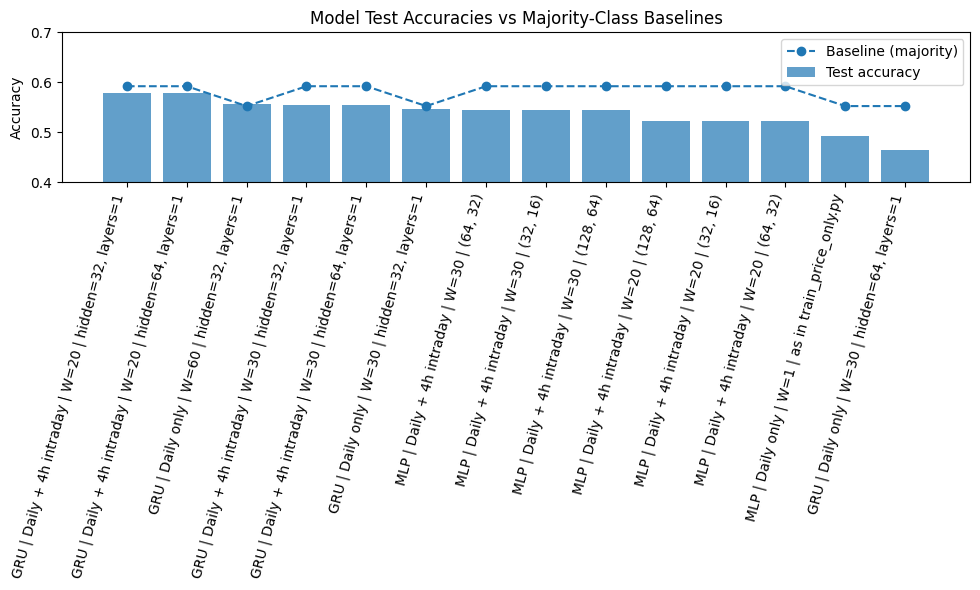

In [5]:
plt.figure(figsize=(10, 6))

labels = []
test_accs = []
baselines = []

for idx, row in results_df_sorted.iterrows():
    label = f"{row['model_family']} | {row['features']} | W={row['window_size']} | {row['hidden_desc']}"
    labels.append(label)
    test_accs.append(row["test_acc"])
    baselines.append(row["baseline_acc"])

x = np.arange(len(labels))

plt.bar(x, test_accs, alpha=0.7, label="Test accuracy")
plt.plot(x, baselines, marker="o", linestyle="--", label="Baseline (majority)")

plt.xticks(x, labels, rotation=75, ha="right")
plt.ylabel("Accuracy")
plt.title("Model Test Accuracies vs Majority-Class Baselines")
plt.ylim(0.4, 0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
summary_by_family = (
    results_df
    .groupby(["model_family", "features"])["test_minus_baseline"]
    .agg(["mean", "max", "min", "count"])
    .reset_index()
)
summary_by_family


,model_family,features,mean,max,min,count
0,GRU,Daily + 4h intraday,-0.025058,-0.013408,-0.036708,4
1,GRU,Daily only,-0.029658,0.003775,-0.087225,3
2,MLP,Daily + 4h intraday,-0.057658,-0.046808,-0.068508,6
3,MLP,Daily only,-0.058825,-0.058825,-0.058825,1
